In [ ]:
import argparse
import json
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

In [ ]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [ ]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [ ]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "F4-1"
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

In [ ]:
# look up the morphology of the organoid from json file
# json_file_path = pathlib.Path("./organoid_image_labels.json").resolve(strict=True)
# with open(json_file_path, "r") as f:
#     organoid_image_labels = json.load(f)
# organoid_image_labels_df = pd.DataFrame(organoid_image_labels)
# # look up the morphology for this well_fov
# morphology = organoid_image_labels_df.loc[
#     organoid_image_labels_df["well_fov"] == well_fov, "label"
# ].values[0]
morphology = "globular"

In [ ]:
return_dict = read_in_channels(
    find_files_available(input_dir),
    channel_dict={
        "nuclei": "405",
        "cyto1": "488",
        "cyto2": "555",
        "cyto3": "640",
        "brightfield": "TRANS",
    },
    channels_to_read=["cyto2"],
)
cyto2_raw = return_dict["cyto2"]
del return_dict
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
nuclei_mask = read_zstack_image(nuclei_mask_output)
# run clip_limit here
cyto2 = skimage.exposure.equalize_adapthist(
    cyto2_raw, clip_limit=clip_limit, kernel_size=None
)
del cyto2_raw

In [12]:
from skimage.segmentation import slic

img = cyto2.copy()

zs, ys, xs = np.meshgrid(
    np.arange(img.shape[0]),
    np.arange(img.shape[1]),
    np.arange(img.shape[2]),
    indexing="ij",
)

points = np.column_stack([xs.ravel(), ys.ravel(), zs.ravel()])
points = points.astype(np.float32)

print(points.shape)  # (N_pixels, 3)

segments = slic(img, n_segments=200, compactness=10, channel_axis=None)

(101780140, 3)


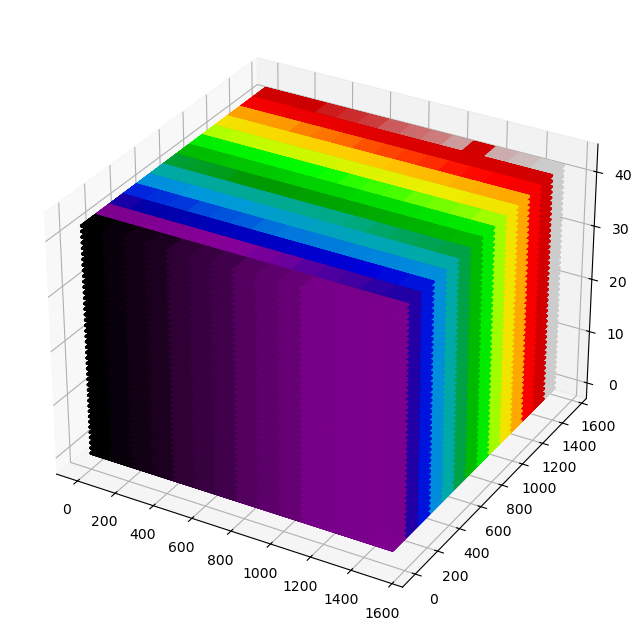

In [13]:
# 3D plot of segments
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    points[:, 0],
    points[:, 1],
    points[:, 2],
    c=segments.ravel(),
    cmap="nipy_spectral",
    s=1,
)
plt.show()